In [1]:
import os
os.chdir('../../')

from dask_cuda import LocalCUDACluster
from dask.distributed import Client


cluster = LocalCUDACluster(
    CUDA_VISIBLE_DEVICES="0,1",
    protocol="ucx",
    enable_tcp_over_ucx=True,
    enable_infiniband=True,
    rmm_managed_memory=True,
    rmm_pool_size='40GB'
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 754.37 GiB
Status: running,Using processes: True
Comm: ucx://127.0.0.1:50995,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 754.37 GiB
Comm: ucx://127.0.0.1:60059,Total threads: 1
Dashboard: http://127.0.0.1:35637/status,Memory: 377.18 GiB
Nanny: ucx://127.0.0.1:51539,


In [25]:
import cudf
import dask
import dask.dataframe as dd

dask.config.set({"dataframe.backend": "cudf"})


cdr = dd.read_parquet('data/processed/201308/cdr_loc')
cdr = cdr[
    (cdr['tower_area_code'] == cdr['calling_area_code'])
    | (cdr['tower_area_code'] == cdr['called_area_code'])
]

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def target2cell_id(target):
    grouped = (
        cdr
        .groupby([target, 'cell_id'])
        .size()
        .reset_index()
        .rename(columns={0: 'counts', target: 'target'})
    )
    total_counts = (
        grouped
        .groupby('target')['counts']
        .sum()
        .reset_index()
        .rename(columns={'counts': 'total_counts'})
    )
    grouped_with_total = grouped.merge(total_counts, on='target', how='left')
    grouped_with_total['ratio'] = grouped_with_total['counts'] / grouped_with_total['total_counts']

    most_frequent_with_ratio = (
        grouped_with_total
        .map_partitions(
            lambda partition: partition.sort_values(by=['target', 'ratio'], ascending=False)
        )
        .drop_duplicates(subset=['target'], keep='first')
    )

    return most_frequent_with_ratio.compute()


def calculate_ratios(threshold, res):
    final_res = res[res.ratio >= threshold]
    target = cdr[
        cdr.client_nbr.isin(final_res.target)
        & cdr.calling_nbr.isin(final_res.target)
        & cdr.called_nbr.isin(final_res.target)
    ][['client_nbr', 'calling_nbr', 'called_nbr', 'cell_id']].compute()

    df = cudf.merge(
        final_res.rename(columns={'target': 'client_nbr', 'cell_id': 'client_cell_id'})[['client_nbr', 'client_cell_id']],
        target,
        on='client_nbr'
    )
    df = cudf.merge(
        final_res.rename(columns={'target': 'calling_nbr', 'cell_id': 'calling_cell_id'})[['calling_nbr', 'calling_cell_id']],
        df,
        on='calling_nbr'
    )
    df = cudf.merge(
        final_res.rename(columns={'target': 'called_nbr', 'cell_id': 'called_cell_id'})[['called_nbr', 'called_cell_id']],
        df,
        on='called_nbr'
    )

    called_ratio = df[df['called_cell_id'] == df['cell_id']].shape[0] / df.shape[0]
    calling_ratio = df[df['calling_cell_id'] == df['cell_id']].shape[0] / df.shape[0]
    client_ratio = df[df['client_cell_id'] == df['cell_id']].shape[0] / df.shape[0]

    return called_ratio, calling_ratio, client_ratio, df


def create_plot(res):
    thresholds = np.arange(0.2, 1.0, 0.1)
    called_ratios = []
    calling_ratios = []
    client_ratios = []

    for threshold in thresholds:
        called_ratio, calling_ratio, client_ratio, _ = calculate_ratios(threshold, res)
        called_ratios.append(called_ratio)
        calling_ratios.append(calling_ratio)
        client_ratios.append(client_ratio)

    plt.figure(figsize=[10,6])
    plt.plot(thresholds, called_ratios, label='Called Ratio', marker='o')
    plt.plot(thresholds, calling_ratios, label='Calling Ratio', marker='o')
    plt.plot(thresholds, client_ratios, label='Client Ratio', marker='o')
    plt.title('Ratios by Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 22.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 19.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending l

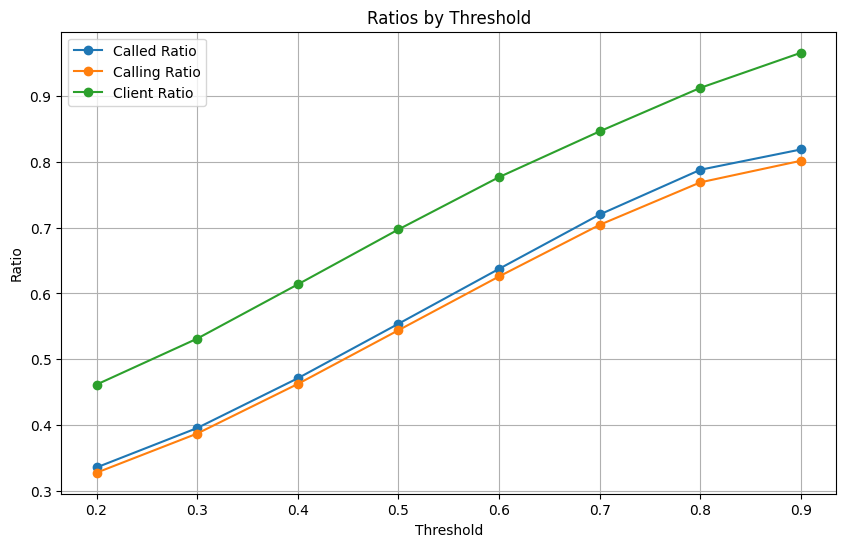

In [4]:
create_plot(target2cell_id('client_nbr'))

/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 134.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 116.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending

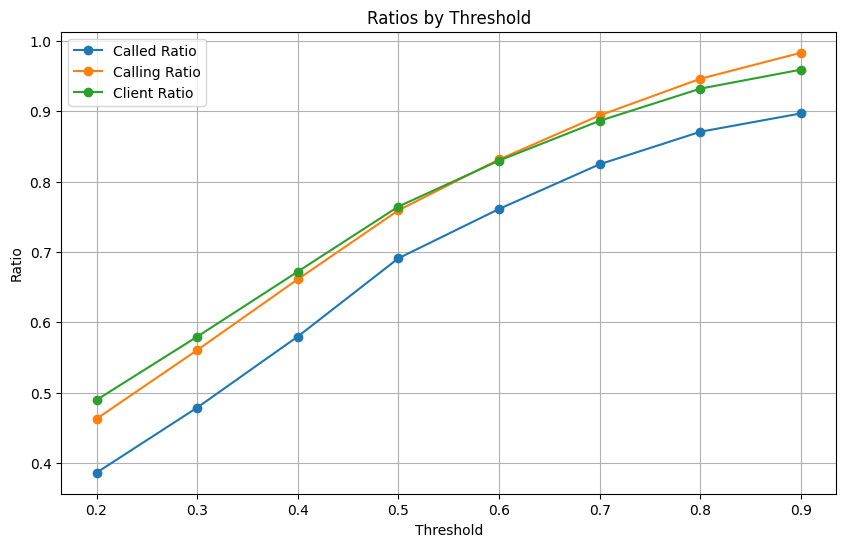

In [5]:
create_plot(target2cell_id('calling_nbr'))

/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 124.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending

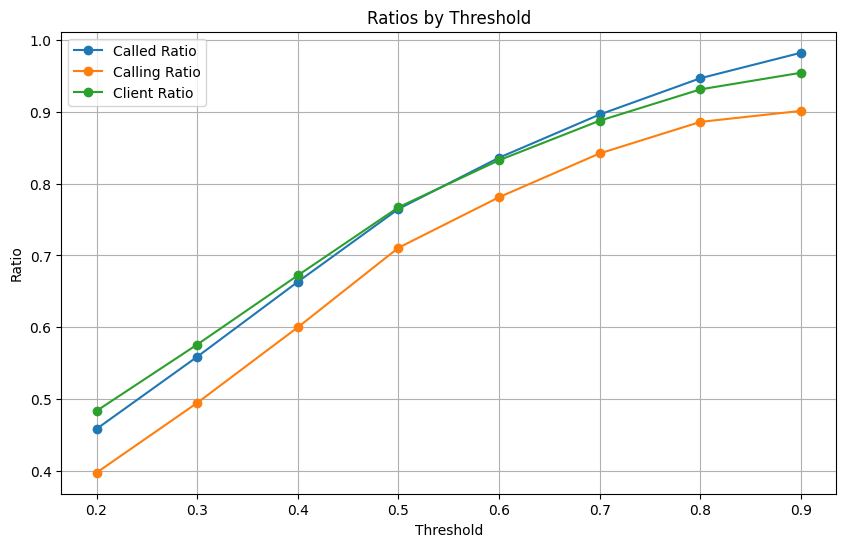

In [6]:
create_plot(target2cell_id('called_nbr'))

In [7]:
_, _, _, df = calculate_ratios(0.7, target2cell_id('client_nbr'))
df.head()

/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/cudf/core/index.py:3369: FutureWarning: cudf.StringIndex is deprecated and will be removed from cudf in a future version. Use cudf.Index with the appropriate dtype instead.
  warnings.warn(


,called_nbr,called_cell_id,calling_nbr,calling_cell_id,client_nbr,client_cell_id,cell_id
0,aohe306t,3683,9en45c7t,3683,9en45c7t,3683,3683
1,kyug5zoe,3804,itp530f9,3488,kyug5zoe,3804,349A
2,3cd32usa,3967,g5fw3i0k,366A,g5fw3i0k,366A,366A
3,kv6q3i66,3911,lq1u3q73,3911,lq1u3q73,3911,3911
4,ejr04wpj,3953,h4hw5cok,3953,h4hw5cok,3953,3953


In [8]:
(
    df[
        (df.calling_cell_id == df.cell_id)
        & (df.calling_nbr == df.client_nbr)
    ].shape[0]
    /
    df[df.calling_cell_id == df.cell_id].shape[0]
)

0.590624514196074

In [9]:
(
    df[
        (df.called_cell_id == df.cell_id)
        & (df.called_nbr == df.client_nbr)
    ].shape[0]
    /
    df[df.called_cell_id == df.cell_id].shape[0]
)

0.5982474205430508